## Predictive Modeling for Anticipating Flight Delays
### Goal: Predict whether a flight will be delayed (15 min or more)

In [1]:
import pandas as pd
import matplotlib.pylab as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve,confusion_matrix
from dmba import plotDecisionTree, classificationSummary
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import data into a pandas dataframe
data = pd.read_csv("FlightDelays.csv")

In [3]:
# See what the dataset looks like
data.head()

,CRS_DEP_TIME,CARRIER,DEP_TIME,DEST,DISTANCE,FL_DATE,FL_NUM,ORIGIN,Weather,DAY_WEEK,DAY_OF_MONTH,TAIL_NUM,Flight Status
0,1455,OH,1455,JFK,184,01/01/2004,5935,BWI,0,4,1,N940CA,ontime
1,1640,DH,1640,JFK,213,01/01/2004,6155,DCA,0,4,1,N405FJ,ontime
2,1245,DH,1245,LGA,229,01/01/2004,7208,IAD,0,4,1,N695BR,ontime
3,1715,DH,1709,LGA,229,01/01/2004,7215,IAD,0,4,1,N662BR,ontime
4,1039,DH,1035,LGA,229,01/01/2004,7792,IAD,0,4,1,N698BR,ontime


In [4]:
data.describe()

,CRS_DEP_TIME,DEP_TIME,DISTANCE,FL_NUM,Weather,DAY_WEEK,DAY_OF_MONTH
count,2201.000000,2201.000000,2201.000000,2201.000000,2201.000000,2201.000000,2201.000000
mean,1371.938664,1369.298955,211.871422,3815.086324,0.014539,3.905498,16.024989
std,432.697149,442.462754,13.316815,2409.750224,0.119725,1.903149,8.677390
min,600.000000,10.000000,169.000000,746.000000,0.000000,1.000000,1.000000
25%,1000.000000,1004.000000,213.000000,2156.000000,0.000000,2.000000,8.000000
50%,1455.000000,1450.000000,214.000000,2385.000000,0.000000,4.000000,16.000000
75%,1710.000000,1709.000000,214.000000,6155.000000,0.000000,5.000000,23.000000
max,2130.000000,2330.000000,229.000000,7924.000000,1.000000,7.000000,31.000000


In [5]:
# View number of (rows, columns) in the dataset
data.shape

(2201, 13)

In [6]:
# List all columns in the dataset
data.columns

Index(['CRS_DEP_TIME', 'CARRIER', 'DEP_TIME', 'DEST', 'DISTANCE', 'FL_DATE',
       'FL_NUM', 'ORIGIN', 'Weather', 'DAY_WEEK', 'DAY_OF_MONTH', 'TAIL_NUM',
       'Flight Status'],
      dtype='object')

In [7]:
# View data types of the columns
data.dtypes

CRS_DEP_TIME      int64
CARRIER          object
DEP_TIME          int64
DEST             object
DISTANCE          int64
FL_DATE          object
FL_NUM            int64
ORIGIN           object
Weather           int64
DAY_WEEK          int64
DAY_OF_MONTH      int64
TAIL_NUM         object
Flight Status    object
dtype: object

In [8]:
# Check dataframe for missing values
data.isna().sum()

CRS_DEP_TIME     0
CARRIER          0
DEP_TIME         0
DEST             0
DISTANCE         0
FL_DATE          0
FL_NUM           0
ORIGIN           0
Weather          0
DAY_WEEK         0
DAY_OF_MONTH     0
TAIL_NUM         0
Flight Status    0
dtype: int64

There are no missing values

In [9]:
data['Flight Status'].value_counts()

ontime     1773
delayed     428
Name: Flight Status, dtype: int64

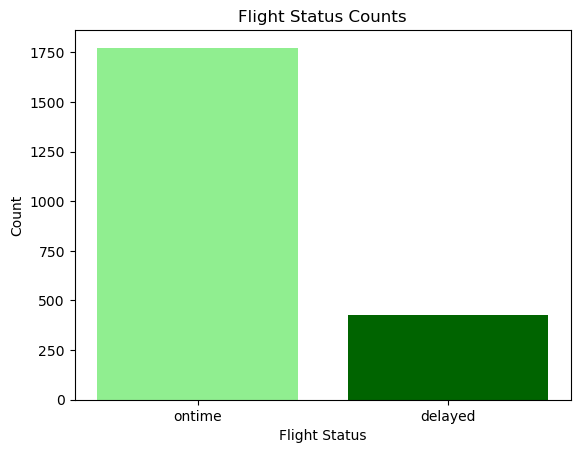

In [10]:
# Count the number of ontime and delayed flights
counts = data['Flight Status'].value_counts()

# Create a bar chart with the counts
plt.bar(counts.index, counts.values, color=['lightgreen', 'darkgreen'])

# Add labels and title
plt.xlabel('Flight Status')
plt.ylabel('Count')
plt.title('Flight Status Counts')

# Show the plot
plt.show()

We observe that the dataset is imbalanced where ontime and delayed flights have a 80:20 split, respectively. Therefore, we'll balance the dataset by oversampling the minority class ('delayed') before training our models in order to improve performance.

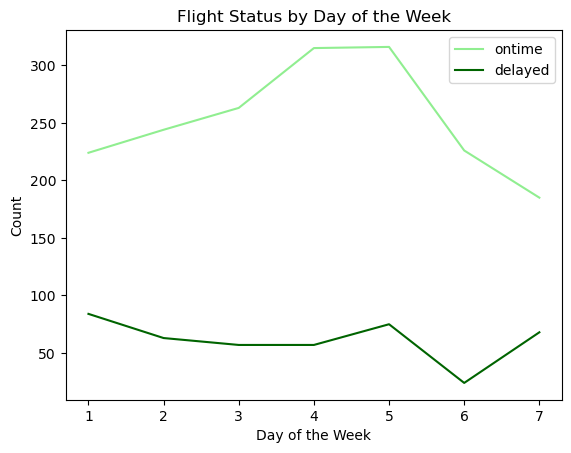

In [11]:
# Count the number of ontime and delayed flights by day of the week
counts_ontime = data[data['Flight Status'] == 'ontime'].groupby('DAY_WEEK').size()
counts_delayed = data[data['Flight Status'] == 'delayed'].groupby('DAY_WEEK').size()

# Create a line graph with the counts
plt.plot(counts_ontime.index, counts_ontime.values, color='lightgreen')
plt.plot(counts_delayed.index, counts_delayed.values, color='darkgreen')

# Add labels and title
plt.xlabel('Day of the Week')
plt.ylabel('Count')
plt.title('Flight Status by Day of the Week')

# Add legend
plt.legend(['ontime', 'delayed'])

# Show the plot
plt.show()

We can see that Thursdays and Fridays are the days with the highest amount of flights ontime. On the other hand, the days with the highest amount of delayed flights are Monday, Fridays and Sundays.

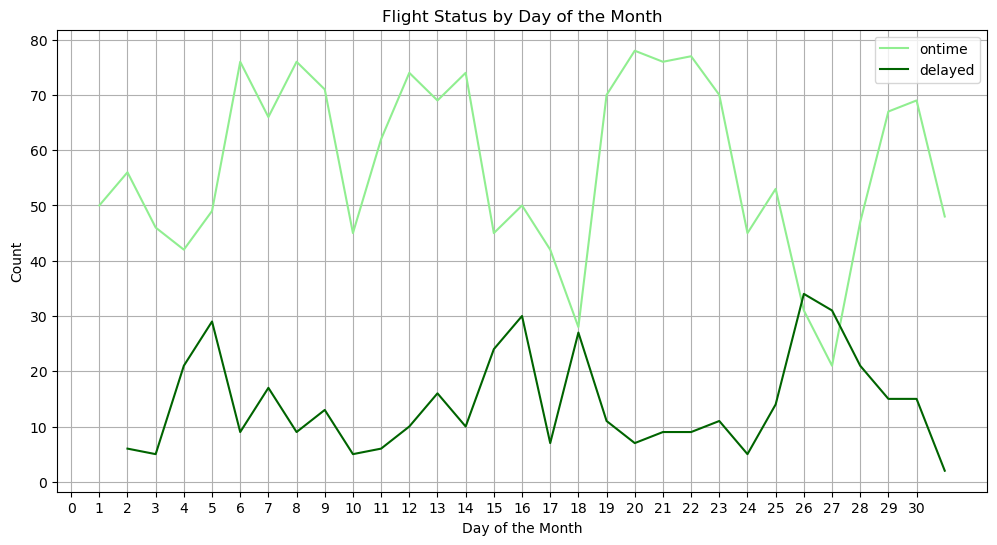

In [12]:
# Count the number of ontime and delayed flights by day of the week
counts_ontime = data[data['Flight Status'] == 'ontime'].groupby('DAY_OF_MONTH').size()
counts_delayed = data[data['Flight Status'] == 'delayed'].groupby('DAY_OF_MONTH').size()

# Create a figure with a larger size
fig = plt.figure(figsize=(12, 6))

# Create a line graph with the counts
plt.plot(counts_ontime.index, counts_ontime.values, color='lightgreen')
plt.plot(counts_delayed.index, counts_delayed.values, color='darkgreen')

# Add labels and title
plt.xlabel('Day of the Month')
plt.ylabel('Count')
plt.title('Flight Status by Day of the Month')

# Add legend
plt.legend(['ontime', 'delayed'])

# Set x-ticks
plt.xticks(range(0, 31))

# Add grid lines
plt.grid(True)

# Show the plot
plt.show()

We can see that the days of the month with the highest amount delayed flights are day 5, 16, 18 and 26 of each month.

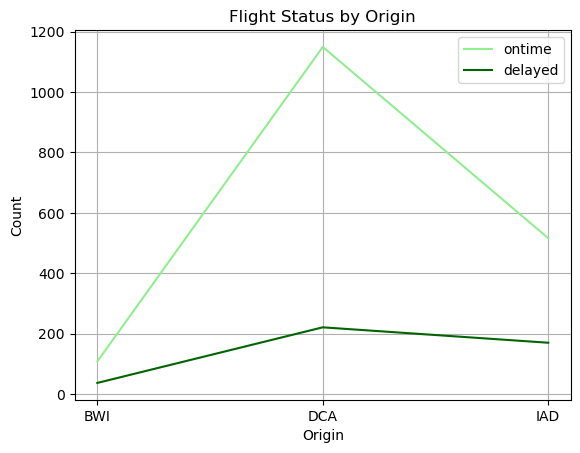

In [13]:
# Count the number of ontime and delayed flights by day of the week
counts_ontime = data[data['Flight Status'] == 'ontime'].groupby('ORIGIN').size()
counts_delayed = data[data['Flight Status'] == 'delayed'].groupby('ORIGIN').size()

# Create a line graph with the counts
plt.plot(counts_ontime.index, counts_ontime.values, color='lightgreen')
plt.plot(counts_delayed.index, counts_delayed.values, color='darkgreen')

# Add labels and title
plt.xlabel('Origin')
plt.ylabel('Count')
plt.title('Flight Status by Origin')

# Add legend
plt.legend(['ontime', 'delayed'])

# Add grid lines
plt.grid(True)

# Show the plot
plt.show()

Ronald Reagan Washington National Airport also known as DCA, is not only the origin airport with the highest amount of ontime flights but also of delayed flights.

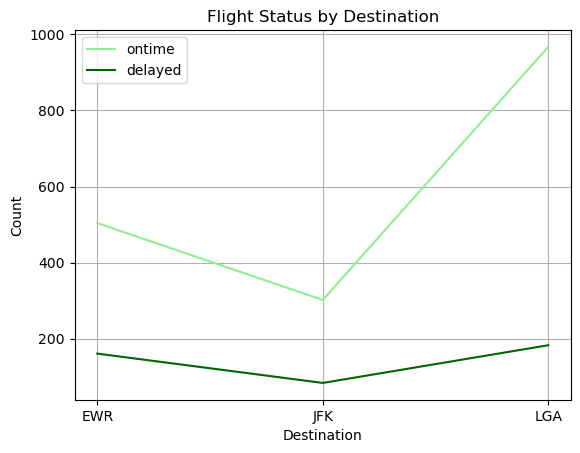

In [14]:
# Count the number of ontime and delayed flights by day of the week
counts_ontime = data[data['Flight Status'] == 'ontime'].groupby('DEST').size()
counts_delayed = data[data['Flight Status'] == 'delayed'].groupby('DEST').size()

# Create a line graph with the counts
plt.plot(counts_ontime.index, counts_ontime.values, color='lightgreen')
plt.plot(counts_delayed.index, counts_delayed.values, color='darkgreen')

# Add labels and title
plt.xlabel('Destination')
plt.ylabel('Count')
plt.title('Flight Status by Destination')

# Add legend
plt.legend(['ontime', 'delayed'])

# Add grid lines
plt.grid(True)

# Show the plot
plt.show()

LaGuardia Airport also known as LGA, is not only the destination airport with the highest amount of ontime flights but also of delayed flights.

# Balancing the dataset by oversampling the minority class ('delayed')

In [15]:
# Select all records classified as 'yes'
yes_df = data[data['Flight Status'] == 'ontime']

# Select all records classified as 'no'
no_df = data[data['Flight Status'] == 'delayed']

# Randomly select an equal number of records classified as 'no'
num_yes = len(yes_df)
no_df_sampled = no_df.sample(n=num_yes, replace=True, random_state=42)  # using a fixed random state for reproducibility

# Combine the selected 'yes' and 'no' records into a single DataFrame
final_df = pd.concat([yes_df, no_df_sampled])

# Shuffle the order of the rows in the DataFrame
final_df = final_df.sample(frac=1, random_state=42)  # using a fixed random state for reproducibility

# Print the first few rows of the final DataFrame to verify the results
final_df.head()

,CRS_DEP_TIME,CARRIER,DEP_TIME,DEST,DISTANCE,FL_DATE,FL_NUM,ORIGIN,Weather,DAY_WEEK,DAY_OF_MONTH,TAIL_NUM,Flight Status
363,2100,US,2104,LGA,214,01/06/2004,2188,DCA,0,2,6,N733UW,ontime
1063,1720,RU,1811,EWR,169,1/15/2004,3372,BWI,0,4,15,N17560,delayed
1691,1715,DH,1715,JFK,228,1/24/2004,7812,IAD,0,6,24,N312UE,delayed
1295,800,MQ,822,LGA,214,1/19/2004,4954,DCA,0,1,19,N717MQ,delayed
1476,700,US,659,LGA,214,1/21/2004,2160,DCA,0,3,21,N713UW,ontime


In [16]:
final_df['Flight Status'].value_counts()

ontime     1773
delayed    1773
Name: Flight Status, dtype: int64

In [17]:
final_df.head()

,CRS_DEP_TIME,CARRIER,DEP_TIME,DEST,DISTANCE,FL_DATE,FL_NUM,ORIGIN,Weather,DAY_WEEK,DAY_OF_MONTH,TAIL_NUM,Flight Status
363,2100,US,2104,LGA,214,01/06/2004,2188,DCA,0,2,6,N733UW,ontime
1063,1720,RU,1811,EWR,169,1/15/2004,3372,BWI,0,4,15,N17560,delayed
1691,1715,DH,1715,JFK,228,1/24/2004,7812,IAD,0,6,24,N312UE,delayed
1295,800,MQ,822,LGA,214,1/19/2004,4954,DCA,0,1,19,N717MQ,delayed
1476,700,US,659,LGA,214,1/21/2004,2160,DCA,0,3,21,N713UW,ontime


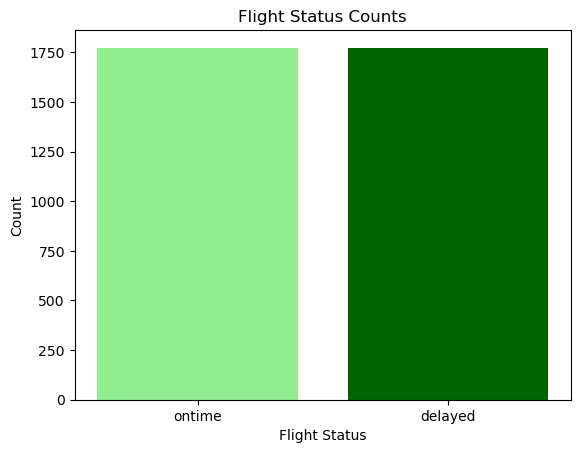

In [18]:
# Count the number of ontime and delayed flights
counts = final_df['Flight Status'].value_counts()

# Create a bar chart with the counts
plt.bar(counts.index, counts.values, color=['lightgreen', 'darkgreen'])

# Add labels and title
plt.xlabel('Flight Status')
plt.ylabel('Count')
plt.title('Flight Status Counts')

# Show the plot
plt.show()

The dataset is now equally balanced between the two classes.

# K-NN

In [19]:
final_df.columns

Index(['CRS_DEP_TIME', 'CARRIER', 'DEP_TIME', 'DEST', 'DISTANCE', 'FL_DATE',
       'FL_NUM', 'ORIGIN', 'Weather', 'DAY_WEEK', 'DAY_OF_MONTH', 'TAIL_NUM',
       'Flight Status'],
      dtype='object')

In [20]:
#Convert the day_week column from numerical into categorical data
final_df.DAY_WEEK = final_df.DAY_WEEK.astype('category')
final_df.DAY_WEEK.dtype

CategoricalDtype(categories=[1, 2, 3, 4, 5, 6, 7], ordered=False)

In [21]:
#bin the times from 6 a.m. (600 hrs) to 11:59 a.m.(2400)
final_df['CRS_DEP_HOUR'] = [round(t/100) for t in final_df['CRS_DEP_TIME']]
final_df['CRS_DEP_HOUR_CAT'] = pd.cut(final_df['CRS_DEP_HOUR'], bins=range(6, 25), labels=range(6, 24), include_lowest=True).astype('category')
print(final_df['CRS_DEP_HOUR_CAT'].cat.categories)

RangeIndex(start=6, stop=24, step=1)


In [22]:
predictors = ['DAY_WEEK','CRS_DEP_HOUR_CAT','ORIGIN','DEST','CARRIER', 'Weather']
X = pd.get_dummies(final_df[predictors])
y = final_df['Flight Status']

In [23]:
X.columns

Index(['Weather', 'DAY_WEEK_1', 'DAY_WEEK_2', 'DAY_WEEK_3', 'DAY_WEEK_4',
       'DAY_WEEK_5', 'DAY_WEEK_6', 'DAY_WEEK_7', 'CRS_DEP_HOUR_CAT_6',
       'CRS_DEP_HOUR_CAT_7', 'CRS_DEP_HOUR_CAT_8', 'CRS_DEP_HOUR_CAT_9',
       'CRS_DEP_HOUR_CAT_10', 'CRS_DEP_HOUR_CAT_11', 'CRS_DEP_HOUR_CAT_12',
       'CRS_DEP_HOUR_CAT_13', 'CRS_DEP_HOUR_CAT_14', 'CRS_DEP_HOUR_CAT_15',
       'CRS_DEP_HOUR_CAT_16', 'CRS_DEP_HOUR_CAT_17', 'CRS_DEP_HOUR_CAT_18',
       'CRS_DEP_HOUR_CAT_19', 'CRS_DEP_HOUR_CAT_20', 'CRS_DEP_HOUR_CAT_21',
       'CRS_DEP_HOUR_CAT_22', 'CRS_DEP_HOUR_CAT_23', 'ORIGIN_BWI',
       'ORIGIN_DCA', 'ORIGIN_IAD', 'DEST_EWR', 'DEST_JFK', 'DEST_LGA',
       'CARRIER_CO', 'CARRIER_DH', 'CARRIER_DL', 'CARRIER_MQ', 'CARRIER_OH',
       'CARRIER_RU', 'CARRIER_UA', 'CARRIER_US'],
      dtype='object')

In [24]:
# Split data into training and testing sets
train_X, valid_X, train_y , valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

In [25]:
results = []
for k in range(1,15):
    knn = KNeighborsClassifier(n_neighbors=k).fit(train_X, train_y)
    results.append({
        'k':k,
        'accuracy': accuracy_score(valid_y, knn.predict(valid_X))
    })

results = pd.DataFrame(results)
print(results)

     k  accuracy
0    1  0.722340
1    2  0.716702
2    3  0.718111
3    4  0.698379
4    5  0.713883
5    6  0.701903
6    7  0.724454
7    8  0.706131
8    9  0.711064
9   10  0.701198
10  11  0.697674
11  12  0.696970
12  13  0.689218
13  14  0.698379


In the code above, different values of K were tested (from 1 to 14) using the training data to check the best accuracy result. From the table above it is showed that k=5 has the best accuracy result, so that is the K value that will be used in the definitive model training, as it can be seen in the code below:

In [26]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(train_X, train_y)

KNeighborsClassifier()

In the code below, the validation part of the dataset is used in the model to get the classification predictions as result.

In [27]:
y_pred = knn.predict(valid_X)

In [28]:
print(classification_report(valid_y, y_pred))

              precision    recall  f1-score   support

     delayed       0.66      0.86      0.75       703
      ontime       0.81      0.57      0.67       716

    accuracy                           0.71      1419
   macro avg       0.73      0.72      0.71      1419
weighted avg       0.74      0.71      0.71      1419



In [29]:
classificationSummary(valid_y, y_pred)

Confusion Matrix (Accuracy 0.7139)

       Prediction
Actual   0   1
     0 605  98
     1 308 408


After running the model and getting the classification predictions as result, this output was compared with the real classification values, and the result of this comparison is showed in the report above, in which it is demonstrated that the model has a 71% accuracy in the classification task.

# Naive Bayes

In [30]:
final_df.head()

,CRS_DEP_TIME,CARRIER,DEP_TIME,DEST,DISTANCE,FL_DATE,FL_NUM,ORIGIN,Weather,DAY_WEEK,DAY_OF_MONTH,TAIL_NUM,Flight Status,CRS_DEP_HOUR,CRS_DEP_HOUR_CAT
363,2100,US,2104,LGA,214,01/06/2004,2188,DCA,0,2,6,N733UW,ontime,21,20
1063,1720,RU,1811,EWR,169,1/15/2004,3372,BWI,0,4,15,N17560,delayed,17,16
1691,1715,DH,1715,JFK,228,1/24/2004,7812,IAD,0,6,24,N312UE,delayed,17,16
1295,800,MQ,822,LGA,214,1/19/2004,4954,DCA,0,1,19,N717MQ,delayed,8,7
1476,700,US,659,LGA,214,1/21/2004,2160,DCA,0,3,21,N713UW,ontime,7,6


In [31]:
#Convert the day_week column from numerical into categorical data
final_df.DAY_WEEK = final_df.DAY_WEEK.astype('category')
final_df.DAY_WEEK.dtype

CategoricalDtype(categories=[1, 2, 3, 4, 5, 6, 7], ordered=False)

In [32]:
#bin the times from 6 a.m. (600 hrs) to 11:59 a.m.(2400)
final_df['CRS_DEP_HOUR'] = [round(t/100) for t in final_df['CRS_DEP_TIME']]
final_df['CRS_DEP_HOUR_CAT'] = pd.cut(final_df['CRS_DEP_HOUR'], bins=range(6, 25), labels=range(6, 24), include_lowest=True).astype('category')
print(final_df['CRS_DEP_HOUR_CAT'].cat.categories)

RangeIndex(start=6, stop=24, step=1)


In [33]:
# Data Partition
#split the data into training (60%) and testing (40%)
predictors = ['DAY_WEEK','CRS_DEP_HOUR_CAT','ORIGIN','DEST','CARRIER']
outcome = 'Flight Status'

X = pd.get_dummies(final_df[predictors])
y = final_df['Flight Status']
classes = ['ontime','delayed']

#split into training and validation
X_train, X_valid, y_train, y_valid = train_test_split(X,y, test_size=0.40,random_state=1)

In [34]:
#Run Naive Bayes 
final_df_nb = MultinomialNB(alpha=0.01)
final_df_nb.fit(X_train, y_train)

#predict probabilities (the belonging probabilities of each record to its particular class)
predProb_train = final_df_nb.predict_proba(X_train)
predProb_valid = final_df_nb.predict_proba(X_valid)

#Convert the predicted probabilities to a pandas data frame as a check and for data visualization purposes
train_df = pd.DataFrame(predProb_train, columns=final_df_nb.classes_)
valid_df = pd.DataFrame(predProb_valid, columns=final_df_nb.classes_)


print("Train Data Prediction Probabilities:\n", train_df.head())
print("\n\nValidation Data Prediction Probabilities:\n", valid_df.head())

Train Data Prediction Probabilities:
     delayed    ontime
0  0.665283  0.334717
1  0.684052  0.315948
2  0.159677  0.840323
3  0.430874  0.569126
4  0.449850  0.550150


Validation Data Prediction Probabilities:
     delayed    ontime
0  0.229165  0.770835
1  0.873309  0.126691
2  0.477537  0.522463
3  0.785632  0.214368
4  0.713656  0.286344


The above code runs the NB model to train the data (X_train and y_train) with a smoothing parameter of 0.01 then we predict the probability of each record belonging to either the training data or validation data
The predicted probabilities and valid probabilities are then turned into pandas df to make it easier to visualize.

In [35]:
#predict the class instead of probability by selecting class with highest probabilities
y_valid_pred = final_df_nb.predict(X_valid)
y_train_pred = final_df_nb.predict(X_train)

Above, we use (y_train_pred) and y_valid_pred to predict which class rather than probability has the for both training data (y_train_pred) and validation data (y_valid_pred)

In [36]:
# Create confusion matrix for training data
cm_train = confusion_matrix(y_train, y_train_pred)

# Convert confusion matrix to a pandas DataFrame
cm_train_df = pd.DataFrame(cm_train, columns=['Predicted Delayed','Predicted On Time'], 
                           index=['Actual Delayed','Actual On Time'])

# Create confusion matrix for validation data
cm_valid = confusion_matrix(y_valid, y_valid_pred)

# Convert confusion matrix to a pandas DataFrame
cm_valid_df = pd.DataFrame(cm_valid, columns=['Predicted Delayed','Predicted On Time'], 
                           index=['Actual Delayed','Actual On Time'])

# Print confusion matrices
print("Training Confusion Matrix:\n")
print(cm_train_df)

print("\nValidation Confusion Matrix:\n")
print(cm_valid_df)

# Create classification report
print("\n\nClassification Report:\n\n",(classification_report(y_valid, y_valid_pred)))

Training Confusion Matrix:

                Predicted Delayed  Predicted On Time
Actual Delayed                717                353
Actual On Time                444                613

Validation Confusion Matrix:

                Predicted Delayed  Predicted On Time
Actual Delayed                475                228
Actual On Time                320                396


Classification Report:

               precision    recall  f1-score   support

     delayed       0.60      0.68      0.63       703
      ontime       0.63      0.55      0.59       716

    accuracy                           0.61      1419
   macro avg       0.62      0.61      0.61      1419
weighted avg       0.62      0.61      0.61      1419



In [37]:
#Change column name
def custom_report(y_true, y_pred):
    report = classification_report(y_true, y_pred)
    return report.replace("f1-score", "f-score").replace("support", "count")

# Usage example
print(custom_report(y_valid, y_valid_pred))

              precision    recall  f-score   count

     delayed       0.60      0.68      0.63       703
      ontime       0.63      0.55      0.59       716

    accuracy                           0.61      1419
   macro avg       0.62      0.61      0.61      1419
weighted avg       0.62      0.61      0.61      1419



# Linear Discriminant Analysis

In [38]:
final_df.head()

,CRS_DEP_TIME,CARRIER,DEP_TIME,DEST,DISTANCE,FL_DATE,FL_NUM,ORIGIN,Weather,DAY_WEEK,DAY_OF_MONTH,TAIL_NUM,Flight Status,CRS_DEP_HOUR,CRS_DEP_HOUR_CAT
363,2100,US,2104,LGA,214,01/06/2004,2188,DCA,0,2,6,N733UW,ontime,21,20
1063,1720,RU,1811,EWR,169,1/15/2004,3372,BWI,0,4,15,N17560,delayed,17,16
1691,1715,DH,1715,JFK,228,1/24/2004,7812,IAD,0,6,24,N312UE,delayed,17,16
1295,800,MQ,822,LGA,214,1/19/2004,4954,DCA,0,1,19,N717MQ,delayed,8,7
1476,700,US,659,LGA,214,1/21/2004,2160,DCA,0,3,21,N713UW,ontime,7,6


In [39]:
#Convert the day_week column from numerical into categorical data
final_df.DAY_WEEK = final_df.DAY_WEEK.astype('category')
final_df.DAY_WEEK.dtype

CategoricalDtype(categories=[1, 2, 3, 4, 5, 6, 7], ordered=False)

In [40]:
#bin the times from 6 a.m. (600 hrs) to 11:59 a.m.(2400)
final_df['CRS_DEP_HOUR'] = [round(t/100) for t in final_df['CRS_DEP_TIME']]
final_df['CRS_DEP_HOUR_CAT'] = pd.cut(final_df['CRS_DEP_HOUR'], bins=range(6, 25), labels=range(6, 24), include_lowest=True).astype('category')
print(final_df['CRS_DEP_HOUR_CAT'])

363     20
1063    16
1691    16
1295     7
1476     6
        ..
1389     7
1571    15
1018    11
2053    20
1638    12
Name: CRS_DEP_HOUR_CAT, Length: 3546, dtype: category
Categories (18, int64): [6 < 7 < 8 < 9 ... 20 < 21 < 22 < 23]


In [41]:
#One-hot encoding for categorical variables
#split the data into training (60%) and testing (40%)
predictors = ['DAY_WEEK','ORIGIN','DEST','CARRIER','Weather','CRS_DEP_HOUR_CAT']
outcome = 'Flight Status'

DA_X = pd.get_dummies(final_df[predictors])
DA_y = final_df['Flight Status']

In [42]:
#split into training and validation
DA_X_train, DA_X_valid, DA_y_train, DA_y_valid = train_test_split(DA_X,DA_y, test_size=0.40,random_state=1)

In [43]:
# Fit LDA model to training data

lda = LinearDiscriminantAnalysis()
lda.fit(DA_X_train, DA_y_train)

LinearDiscriminantAnalysis()

In [44]:
# Make predictions on testing data
DA_y_pred = lda.predict(DA_X_valid)

In [45]:
#Convert Y_pred and Y-test do dataframe 
result = pd.DataFrame({'Predicted': DA_y_pred, 'Actual': DA_y_valid})

# Create the confusion matrix
DA_y_actual = result['Actual']
DA_y_predicted = result['Predicted']

DA_classification_Summary = classificationSummary(DA_y_actual, DA_y_predicted)
print(DA_classification_Summary)

Confusion Matrix (Accuracy 0.6646)

       Prediction
Actual   0   1
     0 488 215
     1 261 455
None


In [46]:
# Create classification report
DA_report = classification_report(DA_y_actual,DA_y_predicted)
print(DA_report)

              precision    recall  f1-score   support

     delayed       0.65      0.69      0.67       703
      ontime       0.68      0.64      0.66       716

    accuracy                           0.66      1419
   macro avg       0.67      0.66      0.66      1419
weighted avg       0.67      0.66      0.66      1419



In [47]:
DA_X_valid.head()

,Weather,DAY_WEEK_1,DAY_WEEK_2,DAY_WEEK_3,DAY_WEEK_4,DAY_WEEK_5,DAY_WEEK_6,DAY_WEEK_7,ORIGIN_BWI,ORIGIN_DCA,...,CRS_DEP_HOUR_CAT_14,CRS_DEP_HOUR_CAT_15,CRS_DEP_HOUR_CAT_16,CRS_DEP_HOUR_CAT_17,CRS_DEP_HOUR_CAT_18,CRS_DEP_HOUR_CAT_19,CRS_DEP_HOUR_CAT_20,CRS_DEP_HOUR_CAT_21,CRS_DEP_HOUR_CAT_22,CRS_DEP_HOUR_CAT_23
1885,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
1335,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1462,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1214,0,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
1360,0,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


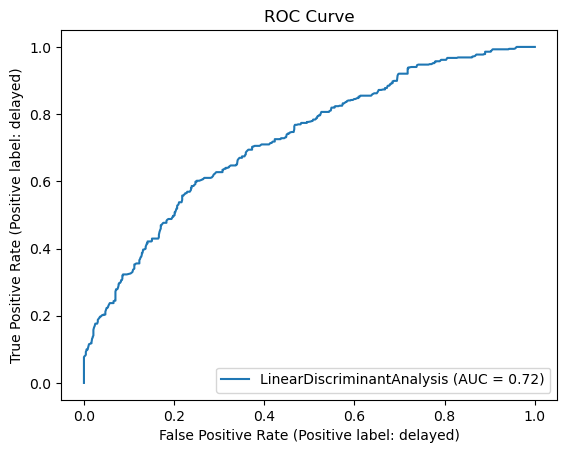

In [49]:
# Create ROC curve plot
plot_roc_curve(lda, DA_X_valid, DA_y_valid, pos_label='delayed')
plt.title('ROC Curve')
plt.show()

### ROC Curver & AUC (Area Under the Curve)

Taking the TPR of 0.8, it means that the model has correctly classified 80% of the positive outcomes, which is "ontime". However at this threshold,the respective FPR is 0.5 which mean it falsely classifies 50% of the "ontime" outcome; or in otherwords, it classfied the 50% "delay" as "on-time". 

AUC of 0.72 which indicate that there is 72% chance  the model will be able to  distinguish between ontime and delay correctly. 
